# REIM Visualization Samples for Presentation and Paper

This notebook gives **sample plotting patterns** for REIM method communication.

- It uses small example data first (replace with your actual results later).
- It builds both **presentation-style** and **paper-style** figures.
- It also exports summary tables in Markdown and LaTeX format.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from pathlib import Path

FIG_DIR = Path('wk4/figures/reim_viz_samples')
FIG_DIR.mkdir(parents=True, exist_ok=True)

METHOD_REIM = 'k-PC Ridge (Re/Im)'
METHOD_EUCLID2 = 'Euclid-2 + Linear'
METHOD_ORDER = ['OF', 'OF+shift', METHOD_REIM, METHOD_EUCLID2]

COLORS = {
    'OF': '#D1495B',
    'OF+shift': '#EDAE49',
    METHOD_REIM: '#00798C',
    METHOD_EUCLID2: '#66A182',
}

HATCHES = {
    'OF': '',
    'OF+shift': '//',
    METHOD_REIM: '',
    METHOD_EUCLID2: 'xx',
}

plt.rcParams.update({
    'figure.dpi': 130,
    'savefig.bbox': 'tight',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11,
})

print('figure output dir:', FIG_DIR)


figure output dir: wk4/figures/reim_viz_samples


## 1) Core Comparison Data (sample)

This table is grouped by:
- `noise` (`mmc`, `pink`, `white`)
- `model` (`PSD`, `SNR2`)
- `method` (`OF`, `OF+shift`, `k-PC Ridge (Re/Im)`, `Euclid-2 + Linear`)

Naming note:
- Instead of plain "REIM", this notebook labels it as **k-PC Ridge (Re/Im)**
  because the workflow is: choose first `k` components, then run linear/ridge regression.


In [15]:
# Euclidean-2 (first two components) + linear fit helper

def euclid2_linear_sigma(coeff, y_true, train_idx, val_idx):
    # Compute sigma from ||[c1, c2]||_2 followed by linear calibration.
    amp2 = np.sqrt(np.sum(np.abs(coeff[:, :2]) ** 2, axis=1))

    M = np.column_stack([amp2[train_idx], np.ones(len(train_idx))])
    a, b = np.linalg.lstsq(M, y_true[train_idx], rcond=None)[0]

    y_pred = a * amp2[val_idx] + b
    resid = y_true[val_idx] - y_pred
    sigma = np.std(resid, ddof=1)
    return float(sigma), float(a), float(b)


noise_order = ['mmc', 'pink', 'white']
model_order = ['PSD', 'SNR2']

# OF baselines are noise-specific (not trained separately for PSD/SNR2),
# so values are duplicated under each model column for side-by-side comparison.
of_sigma_noise = {'mmc': 7.816658, 'pink': 21.780283, 'white': 4.707320}
of_shift_sigma_noise = {'mmc': 6.493218, 'pink': 20.994062, 'white': 3.686814}

# Example REIM (renamed as k-PC Ridge) results from current pattern.
reim_sigma_by_model = {
    ('mmc', 'PSD'): 7.393366,
    ('mmc', 'SNR2'): 5.677784,
    ('pink', 'PSD'): 21.849867,
    ('pink', 'SNR2'): 20.225714,
    ('white', 'PSD'): 1.144652,
    ('white', 'SNR2'): 1.002644,
}

# Example Euclidean-2 baseline values (replace with measured k=2 values).
euclid2_sigma_by_model = {
    ('mmc', 'PSD'): 13.40,
    ('mmc', 'SNR2'): 19.10,
    ('pink', 'PSD'): 28.60,
    ('pink', 'SNR2'): 31.70,
    ('white', 'PSD'): 9.90,
    ('white', 'SNR2'): 10.70,
}

rows = []
for noise in noise_order:
    for model in model_order:
        rows.append({'noise': noise, 'model': model, 'method': 'OF', 'sigma': of_sigma_noise[noise]})
        rows.append({'noise': noise, 'model': model, 'method': 'OF+shift', 'sigma': of_shift_sigma_noise[noise]})
        rows.append({'noise': noise, 'model': model, 'method': METHOD_REIM, 'sigma': reim_sigma_by_model[(noise, model)]})
        rows.append({'noise': noise, 'model': model, 'method': METHOD_EUCLID2, 'sigma': euclid2_sigma_by_model[(noise, model)]})

df_sigma = pd.DataFrame(rows)

display(df_sigma.sort_values(['noise', 'model', 'method']))


,noise,model,method,sigma
3,mmc,PSD,Euclid-2 + Linear,13.400000
0,mmc,PSD,OF,7.816658
1,mmc,PSD,OF+shift,6.493218
2,mmc,PSD,k-PC Ridge (Re/Im),7.393366
7,mmc,SNR2,Euclid-2 + Linear,19.100000
4,mmc,SNR2,OF,7.816658
5,mmc,SNR2,OF+shift,6.493218
6,mmc,SNR2,k-PC Ridge (Re/Im),5.677784
11,pink,PSD,Euclid-2 + Linear,28.600000
8,pink,PSD,OF,21.780283


## 2) Figure for Presentation: Grouped Bar Chart (Clean Style)

Simple layout with clear grouping by `noise + model` and no decorative overlays.


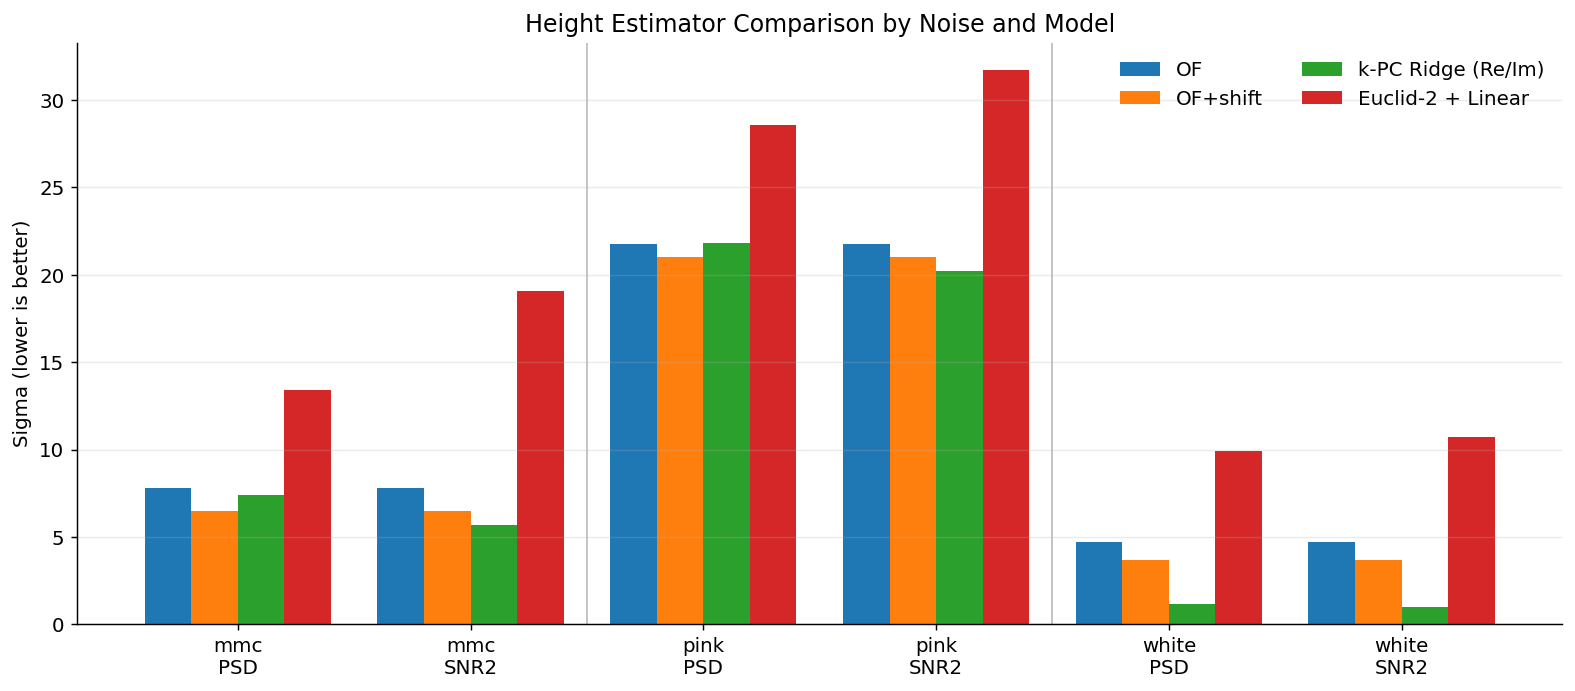

In [16]:
group_keys = [(n, m) for n in noise_order for m in model_order]
x = np.arange(len(group_keys))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 5.2), constrained_layout=True)

for i, method in enumerate(METHOD_ORDER):
    vals = [
        float(df_sigma[(df_sigma['noise'] == n) & (df_sigma['model'] == m) & (df_sigma['method'] == method)]['sigma'].iloc[0])
        for n, m in group_keys
    ]
    offset = (i - (len(METHOD_ORDER) - 1) / 2) * width
    ax.bar(x + offset, vals, width=width, label=method)

# separator lines between noise blocks (2 groups per noise)
for boundary in [1.5, 3.5]:
    ax.axvline(boundary, color='0.75', linewidth=1.0)

ax.set_xticks(x)
ax.set_xticklabels([f'{n}\n{m}' for n, m in group_keys])
ax.set_ylabel('Sigma (lower is better)')
ax.set_title('Height Estimator Comparison by Noise and Model')
ax.grid(axis='y', alpha=0.25)
ax.legend(frameon=False, ncol=2)

fig.savefig(FIG_DIR / 'presentation_bar_by_noise_model_methods.png', dpi=260)
plt.show()


## 3) Figure for Paper: Sigma vs Number of Components k

This shows model behavior, not only final best point.
Use your real sigma-by-k values from experiments.


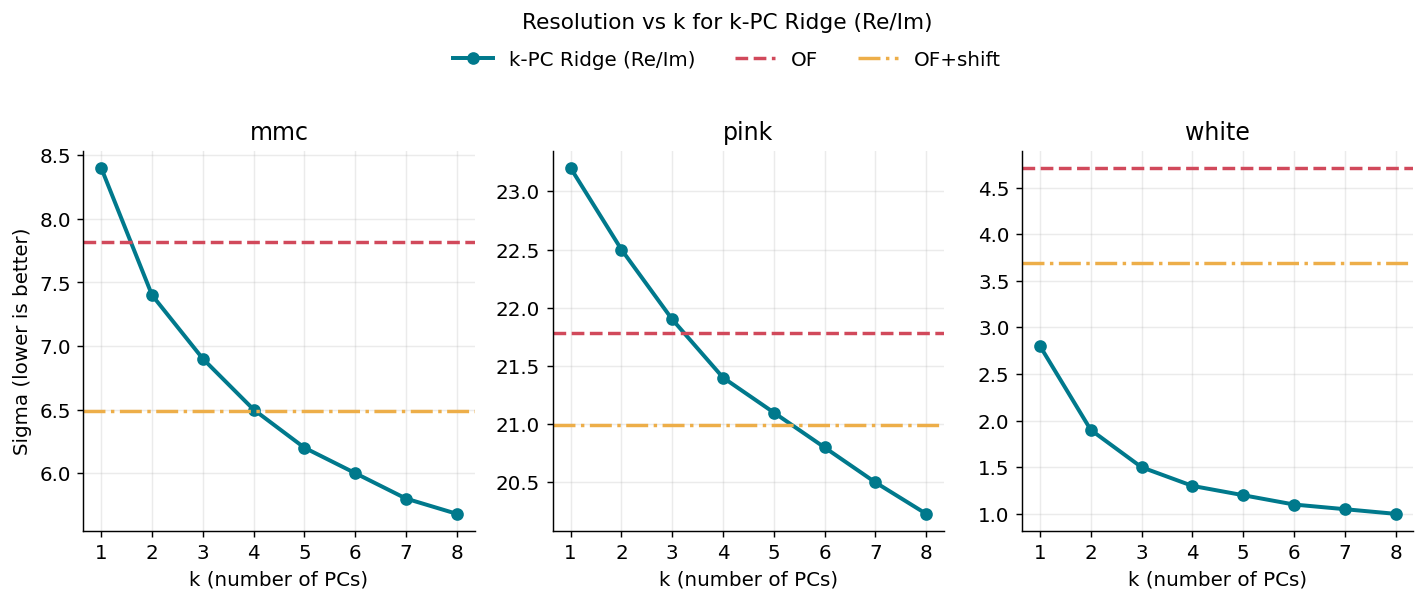

In [17]:
k_vals = np.arange(1, 9)

# Example curves. Replace these with measured values from your notebook runs.
reim_sigma_by_noise = {
    'mmc':  [8.4, 7.4, 6.9, 6.5, 6.2, 6.0, 5.8, 5.68],
    'pink': [23.2, 22.5, 21.9, 21.4, 21.1, 20.8, 20.5, 20.23],
    'white':[2.8, 1.9, 1.5, 1.3, 1.2, 1.1, 1.05, 1.00],
}

of_sigma = {'mmc': 7.82, 'pink': 21.78, 'white': 4.71}
of_shift_sigma = {'mmc': 6.49, 'pink': 20.99, 'white': 3.69}

fig, axes = plt.subplots(1, 3, figsize=(13.2, 3.8), sharey=False)
for ax, noise in zip(axes, ['mmc', 'pink', 'white']):
    ax.plot(k_vals, reim_sigma_by_noise[noise], marker='o', color=COLORS[METHOD_REIM], linewidth=2.2, label=METHOD_REIM)
    ax.axhline(of_sigma[noise], color=COLORS['OF'], linestyle='--', linewidth=1.9, label='OF')
    ax.axhline(of_shift_sigma[noise], color=COLORS['OF+shift'], linestyle='-.', linewidth=1.9, label='OF+shift')
    ax.set_title(noise)
    ax.set_xlabel('k (number of PCs)')
    ax.set_xticks(k_vals)
    ax.grid(alpha=0.25)

axes[0].set_ylabel('Sigma (lower is better)')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.12))
fig.suptitle('Resolution vs k for k-PC Ridge (Re/Im)', y=1.16, fontsize=12)

fig.savefig(FIG_DIR / 'paper_sigma_vs_k_reim_of.png', dpi=300)
plt.show()


## 4) Optional Diagnostic Figure: Parity + Residuals

Useful in appendix or backup slide.


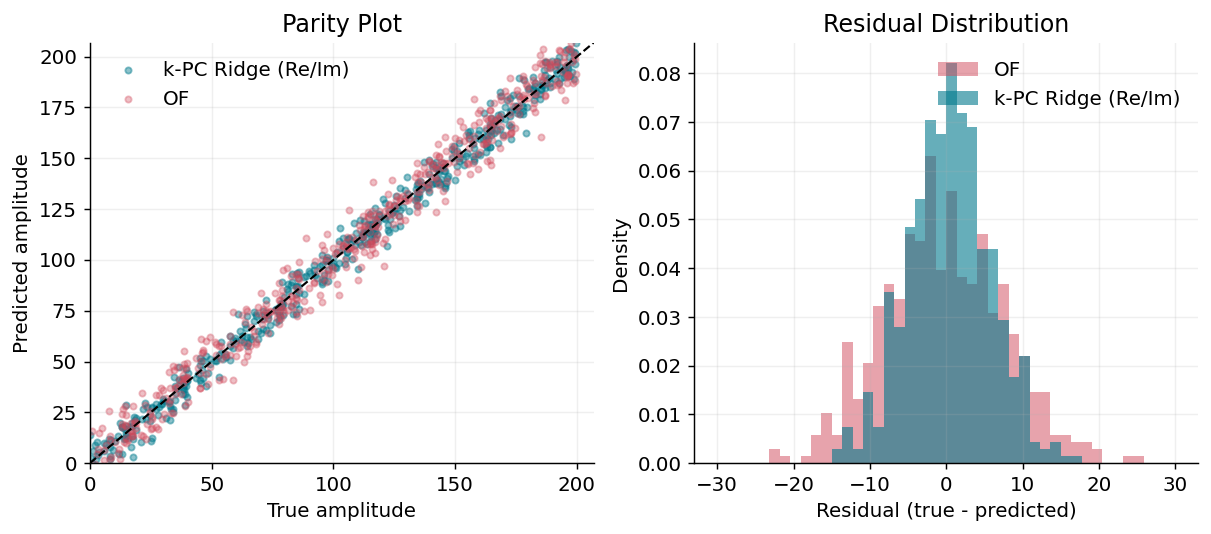

In [18]:
rng = np.random.default_rng(0)
n = 500
a_true = rng.uniform(0, 200, size=n)

def noisy_pred(y_true, sigma):
    return y_true + rng.normal(0, sigma, size=len(y_true))

pred_reim = noisy_pred(a_true, sigma=5.7)
pred_of = noisy_pred(a_true, sigma=7.8)

res_reim = a_true - pred_reim
res_of = a_true - pred_of

fig, axes = plt.subplots(1, 2, figsize=(11, 4.2))

# Parity
axes[0].scatter(a_true, pred_reim, s=12, alpha=0.45, color=COLORS[METHOD_REIM], label=METHOD_REIM)
axes[0].scatter(a_true, pred_of, s=12, alpha=0.35, color=COLORS['OF'], label='OF')
lims = [0, max(a_true.max(), pred_reim.max(), pred_of.max())]
axes[0].plot(lims, lims, 'k--', linewidth=1.2)
axes[0].set_xlim(lims)
axes[0].set_ylim(lims)
axes[0].set_xlabel('True amplitude')
axes[0].set_ylabel('Predicted amplitude')
axes[0].set_title('Parity Plot')
axes[0].legend(frameon=False)
axes[0].grid(alpha=0.2)

# Residual histogram
bins = np.linspace(-30, 30, 45)
axes[1].hist(res_of, bins=bins, alpha=0.5, color=COLORS['OF'], label='OF', density=True)
axes[1].hist(res_reim, bins=bins, alpha=0.6, color=COLORS[METHOD_REIM], label=METHOD_REIM, density=True)
axes[1].set_xlabel('Residual (true - predicted)')
axes[1].set_ylabel('Density')
axes[1].set_title('Residual Distribution')
axes[1].legend(frameon=False)
axes[1].grid(alpha=0.2)

fig.savefig(FIG_DIR / 'diagnostic_parity_residual.png', dpi=260)
plt.show()


## 5) Table Export for Paper

This table keeps `noise` + `model` split and includes relative improvements.


In [19]:
table = (
    df_sigma
    .pivot_table(index=['noise', 'model'], columns='method', values='sigma', aggfunc='first')
    .reset_index()
)

table['OF->OF+shift (%)'] = 100.0 * (table['OF'] - table['OF+shift']) / table['OF']
table['OF->k-PC Ridge (%)'] = 100.0 * (table['OF'] - table[METHOD_REIM]) / table['OF']
table['OF->Euclid2 (%)'] = 100.0 * (table['OF'] - table[METHOD_EUCLID2]) / table['OF']

order = ['noise', 'model', 'OF', 'OF+shift', METHOD_REIM, METHOD_EUCLID2,
         'OF->OF+shift (%)', 'OF->k-PC Ridge (%)', 'OF->Euclid2 (%)']
table = table[order].sort_values(['noise', 'model'])

# Rounded display version
round_cols = [c for c in table.columns if c not in ['noise', 'model']]
table_disp = table.copy()
for c in round_cols:
    table_disp[c] = table_disp[c].map(lambda x: f'{x:.2f}')

display(table_disp)

print('Markdown table:')
print(table_disp.to_markdown(index=False))
print()
print('LaTeX table:')
print(table_disp.to_latex(index=False, escape=False))


method,noise,model,OF,OF+shift,k-PC Ridge (Re/Im),Euclid-2 + Linear,OF->OF+shift (%),OF->k-PC Ridge (%),OF->Euclid2 (%)
0,mmc,PSD,7.82,6.49,7.39,13.40,16.93,5.42,-71.43
1,mmc,SNR2,7.82,6.49,5.68,19.10,16.93,27.36,-144.35
2,pink,PSD,21.78,20.99,21.85,28.60,3.61,-0.32,-31.31
3,pink,SNR2,21.78,20.99,20.23,31.70,3.61,7.14,-45.54
4,white,PSD,4.71,3.69,1.14,9.90,21.68,75.68,-110.31
5,white,SNR2,4.71,3.69,1.00,10.70,21.68,78.70,-127.31


Markdown table:
| noise   | model   |    OF |   OF+shift |   k-PC Ridge (Re/Im) |   Euclid-2 + Linear |   OF->OF+shift (%) |   OF->k-PC Ridge (%) |   OF->Euclid2 (%) |
|:--------|:--------|------:|-----------:|---------------------:|--------------------:|-------------------:|---------------------:|------------------:|
| mmc     | PSD     |  7.82 |       6.49 |                 7.39 |                13.4 |              16.93 |                 5.42 |            -71.43 |
| mmc     | SNR2    |  7.82 |       6.49 |                 5.68 |                19.1 |              16.93 |                27.36 |           -144.35 |
| pink    | PSD     | 21.78 |      20.99 |                21.85 |                28.6 |               3.61 |                -0.32 |            -31.31 |
| pink    | SNR2    | 21.78 |      20.99 |                20.23 |                31.7 |               3.61 |                 7.14 |            -45.54 |
| white   | PSD     |  4.71 |       3.69 |                 1.14 |       

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

## How to adapt quickly

1. Replace `reim_sigma_by_model` with your measured values for each `(noise, model)`.
2. Replace `euclid2_sigma_by_model` with measured values from `euclid2_linear_sigma(...)`.
3. Keep `METHOD_REIM` label consistent across all figures and tables.
4. For paper-ready output, keep bar colors consistent and export at 300 dpi.
